<a href="https://colab.research.google.com/github/Sayed-Hossein-Hosseini/A_Journey_into_the_Depths_of_Neural_Networks/blob/master/Diversity_of_Networks_and_Optimizers_for_Progress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diversity of Networks and Optimizers for Progress**

## **Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

## **Loading Dataset and Normalization**

In [2]:
if __name__ == "__main__":
    # Load in the data
    cifar10 = tf.keras.datasets.cifar10

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0

    print(X_train.shape)
    print(X_test.shape)

    print(y_train.shape)
    print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## **Flatten and Reshape Images**

In [3]:
if __name__ == "__main__":
    # reshape images from (32, 32, 3) to (3072,)
    X_train = X_train.reshape((X_train.shape[0], -1))  # (50000, 3072)
    X_test = X_test.reshape((X_test.shape[0], -1))     # (10000, 3072)

    y_train, y_test = y_train.flatten(), y_test.flatten() # (50000,  -   10000,)
    print(y_train[:10])

[6 9 9 4 1 1 2 7 8 3]


## **One-Hot Encoding**

In [4]:
y_train = to_categorical(y_train, num_classes=10)
# y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
# print(y_test.shape)

print(y_train[:10])
# print(y_test[:10])

(50000, 10)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## **Model**

### **Activation Function : Sigmoid and Relu and Softmax and Tanh**

In [5]:
class Activation:
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def sigmoid_derivative(a):
        return a * (1 - a)

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(float)

    @staticmethod
    def softmax(z):
        exps = np.exp(z - np.max(z, axis=1, keepdims=True))  # For numerical stability
        return exps / np.sum(exps, axis=1, keepdims=True)

    @staticmethod
    def softmax_derivative(output):
        # The exact derivative of softmax is a Jacobian matrix.
        # However, when used with cross-entropy loss, the gradient simplifies to:
        # ∂L/∂z = y_pred - y_true
        # So this method is typically not needed explicitly during backpropagation.
        pass

    @staticmethod
    def tanh(z):
        return np.tanh(z)

    @staticmethod
    def tanh_derivative(a):
        return 1 - np.power(a, 2)

## **Neural Network**

### **Dence Layer Class**

In [6]:
class DenseLayer:
    def __init__(self, input_size, output_size, activation='sigmoid'):
        self.w = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))
        self.activation_name = activation
        self.z = None
        self.a = None
        self.input = None
        self.dw = None
        self.db = None

    def forward(self, x):
        self.input = x
        self.z = np.dot(x, self.w) + self.b
        if self.activation_name == 'sigmoid':
            self.a = Activation.sigmoid(self.z)
        elif self.activation_name == 'relu':
            self.a = Activation.relu(self.z)
        elif self.activation_name == 'tanh':
            self.a = Activation.tanh(self.z)
        elif self.activation_name == 'softmax':
            self.a = Activation.softmax(self.z)
        else:
            raise ValueError(f"Unsupported activation function: {self.activation_name}")
        return self.a

    def backward(self, da):
        m = self.input.shape[0]
        if self.activation_name == 'sigmoid':
            dz = da * Activation.sigmoid_derivative(self.a)
        elif self.activation_name == 'relu':
            dz = da * Activation.relu_derivative(self.z)
        elif self.activation_name == 'tanh':
            dz = da * Activation.tanh_derivative(self.a)
        elif self.activation_name == 'softmax':
            dz = da  # softmax + cross-entropy
        else:
            raise ValueError(f"Unsupported activation function: {self.activation_name}")

        self.dw = np.dot(self.input.T, dz) / m
        self.db = np.sum(dz, axis=0, keepdims=True) / m
        return np.dot(dz, self.w.T)

### **Optimizer Classes**

In [7]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, layer):
        layer.w -= self.lr * layer.dw
        layer.b -= self.lr * layer.db


class Momentum:
    def __init__(self, lr=0.01, beta=0.9):
        self.lr = lr
        self.beta = beta
        self.v_w = {}
        self.v_b = {}

    def update(self, layer):
        if layer not in self.v_w:
            self.v_w[layer] = np.zeros_like(layer.w)
            self.v_b[layer] = np.zeros_like(layer.b)
        self.v_w[layer] = self.beta * self.v_w[layer] + (1 - self.beta) * layer.dw
        self.v_b[layer] = self.beta * self.v_b[layer] + (1 - self.beta) * layer.db
        layer.w -= self.lr * self.v_w[layer]
        layer.b -= self.lr * self.v_b[layer]


class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w, self.v_w = {}, {}
        self.m_b, self.v_b = {}, {}
        self.t = {}

    def update(self, layer):
        if layer not in self.m_w:
            self.m_w[layer] = np.zeros_like(layer.w)
            self.v_w[layer] = np.zeros_like(layer.w)
            self.m_b[layer] = np.zeros_like(layer.b)
            self.v_b[layer] = np.zeros_like(layer.b)
            self.t[layer] = 0

        self.t[layer] += 1

        self.m_w[layer] = self.beta1 * self.m_w[layer] + (1 - self.beta1) * layer.dw
        self.v_w[layer] = self.beta2 * self.v_w[layer] + (1 - self.beta2) * (layer.dw ** 2)
        self.m_b[layer] = self.beta1 * self.m_b[layer] + (1 - self.beta1) * layer.db
        self.v_b[layer] = self.beta2 * self.v_b[layer] + (1 - self.beta2) * (layer.db ** 2)

        m_w_hat = self.m_w[layer] / (1 - self.beta1 ** self.t[layer])
        v_w_hat = self.v_w[layer] / (1 - self.beta2 ** self.t[layer])
        m_b_hat = self.m_b[layer] / (1 - self.beta1 ** self.t[layer])
        v_b_hat = self.v_b[layer] / (1 - self.beta2 ** self.t[layer])

        layer.w -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
        layer.b -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

### **Neural Network Class**

In [8]:
class NeuralNetwork:
    def __init__(self, optimizer):
        self.layers = []
        self.optimizer = optimizer
        self.loss_history = []
        self.accuracy_history = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-8
        if y_true.shape[1] == 1:  # Binary classification
            return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
        else:  # Multi-class classification
            return -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))

    def backward(self, y_true, y_pred):
        if y_true.shape[1] == 1:  # Binary classification
            dz = y_pred - y_true
        else:  # Multi-class classification
            dz = y_pred - y_true
        gradient = dz

        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def update_weights(self):
        for layer in self.layers:
            self.optimizer.update(layer)

    def train(self, X, y, epochs=100, batch_size=64, verbose=True):
        for epoch in range(epochs):
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = []

            for i in range(0, X.shape[0], batch_size):
                x_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                output = self.forward(x_batch)
                loss = self.compute_loss(y_batch, output)
                epoch_loss.append(loss)

                self.backward(y_batch, output)
                self.update_weights()

            # ذخیره‌سازی
            loss_value = np.mean(epoch_loss)
            accuracy = self.evaluate_accuracy(X, y)

            self.loss_history.append(loss_value)
            self.accuracy_history.append(accuracy)

            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {loss_value:.4f}, Accuracy = {accuracy:.4f}")


    def predict(self, X):
        y_pred = self.forward(X)
        if y_pred.shape[1] == 1:
            return (y_pred >= 0.5).astype(int)
        else:
            return np.argmax(y_pred, axis=1)

    def evaluate_accuracy(self, X, y):
        y_pred = self.predict(X)
        if y.shape[1] == 1:
            y_true = y
            return np.mean(y_pred == y_true)
        else:
            y_true = np.argmax(y, axis=1)
            return np.mean(y_pred == y_true)

### **Plot Metrics**

In [9]:
def plot_metrics(nn):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(nn.loss_history, label="Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(nn.accuracy_history, label="Accuracy", color='green')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

## **Main**

In [10]:
optimizer = Momentum(lr=0.05)
nn = NeuralNetwork(optimizer=optimizer)

nn.add(DenseLayer(3072, 64, activation='sigmoid'))
nn.add(DenseLayer(64, 10, activation='softmax'))

nn.train(X_train, y_train, epochs=1000, batch_size=64)
predictions = nn.predict(X_test)

Epoch 0: Loss = 2.1709, Accuracy = 0.2436
Epoch 10: Loss = 1.6022, Accuracy = 0.4302
Epoch 20: Loss = 1.4635, Accuracy = 0.4962
Epoch 30: Loss = 1.3782, Accuracy = 0.5217
Epoch 40: Loss = 1.3217, Accuracy = 0.5428
Epoch 50: Loss = 1.2726, Accuracy = 0.5513
Epoch 60: Loss = 1.2341, Accuracy = 0.5674
Epoch 70: Loss = 1.2017, Accuracy = 0.5747
Epoch 80: Loss = 1.1724, Accuracy = 0.5937
Epoch 90: Loss = 1.1425, Accuracy = 0.6014
Epoch 100: Loss = 1.1154, Accuracy = 0.6167
Epoch 110: Loss = 1.0896, Accuracy = 0.6200
Epoch 120: Loss = 1.0683, Accuracy = 0.6299
Epoch 130: Loss = 1.0495, Accuracy = 0.6434
Epoch 140: Loss = 1.0316, Accuracy = 0.6453
Epoch 150: Loss = 1.0137, Accuracy = 0.6429
Epoch 160: Loss = 0.9902, Accuracy = 0.6681
Epoch 170: Loss = 0.9732, Accuracy = 0.6625
Epoch 180: Loss = 0.9603, Accuracy = 0.6716
Epoch 190: Loss = 0.9453, Accuracy = 0.6753
Epoch 200: Loss = 0.9218, Accuracy = 0.6824
Epoch 210: Loss = 0.9111, Accuracy = 0.6903
Epoch 220: Loss = 0.9018, Accuracy = 0.6858

## **Model Training Analysis**

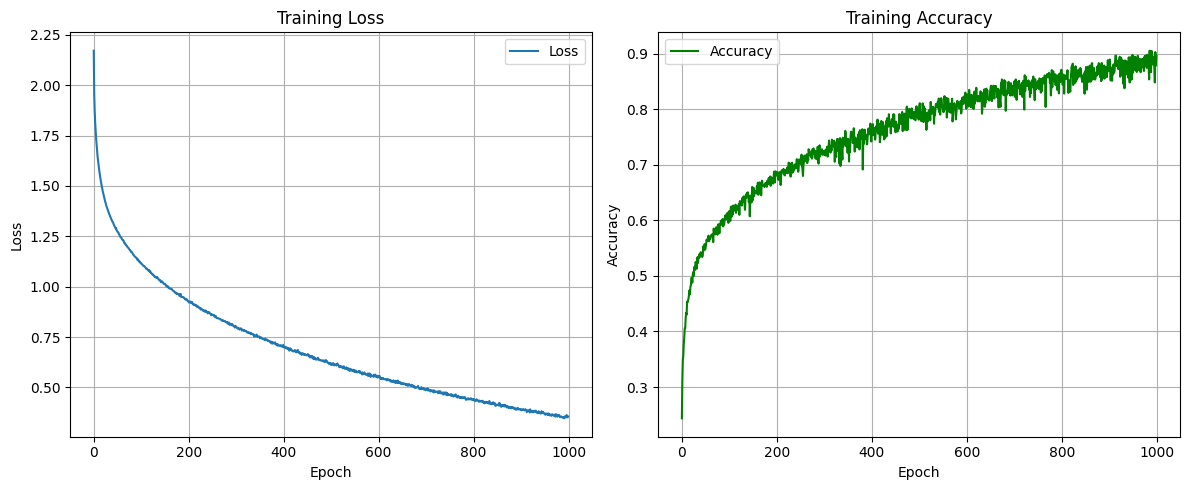

In [11]:
plot_metrics(nn)